## Possible Defaulters for Customer Loan Products

<h1>1. Business Problem</h1>

<h2>1.1. Description</h2>

<h4> Problem statement : </h4>
<p> Given the customer's personal, demographics financial and historical data, predict who are the possible defaulters for the consumer loans product </p>

<h2>1.2. Real-world/Business objectives and constraints.</h2>

* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.

<h1>2. Machine Learning Problem Formulation</h1>

<h2>2.1. Data</h2>

<h3>2.1.1. Data Overview</h3>

- Training Data has 252,000 columns and 13 features including the class label.
- <p> 
    Data file's information:
    <ul> 
        <li>
        Training Data (ID, Income, Age, Experience, Married/Single,	House_Ownership, Car_Ownership	Profession, CITY, STATE, CURRENT_JOB_YRS, CURRENT_HOUSE_YRS, Risk_Flag)
        </li>
    </ul>
</p>

<h2>2.2. Mapping the real-world problem to an ML problem</h2>

<h3>2.2.1. Type of Machine Learning Problem</h3>

<p>
    The task is to predict whether a Cutomer is defaulter or not. It is a Binary Class classification.
</p>

<h3>2.2.2. Performance Metric</h3>

Metric(s): 
* AUC ROC 
* Confusion matrix 

<h3>2.2.3. Machine Learing Objectives and Constraints</h3>

<p><strong>Objective:</strong> Predict whether a Customer is a defaulter or not.</p>

<p><strong>Constraints:</strong></p>
<ul>
    <li>Interpretability</li>
    <li>Highly Imbalanced Data</li>
    <li>No Latency Constraints</li>
</ul>

<h2>2.3. Train and Test Datasets</h2>

Train and Test datasets are given seperately as Train Data.csv and Test Data.csv respectively
- Training Data has 252,000 columns and 13 features including the class label.
- Test Data has 28,000 columns and 13 features including the class label.

<h1>3. Exploratory Data Analysis</h1>

<h2>3.1 Reading Data</h2>

In [1]:
import os
import pandas as pd
import re
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
# from sklearn.metrics import plot_roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from category_encoders.target_encoder import TargetEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [2]:
data=pd.read_csv('Training Data.csv', usecols=lambda x:x!='Id')
data.head()

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [3]:
data.columns

Index(['Income', 'Age', 'Experience', 'Married/Single', 'House_Ownership',
       'Car_Ownership', 'Profession', 'CITY', 'STATE', 'CURRENT_JOB_YRS',
       'CURRENT_HOUSE_YRS', 'Risk_Flag'],
      dtype='object')

In [4]:
data.rename(columns={'Id':'id', 'Income':'income', 'Age':'age', 'Experience':'experience', 
                    'Married/Single':'is_married', 'House_Ownership':'house_ownership', 
                     'Car_Ownership':'car_ownership',
                     'Profession':'profession', 'CITY':'city', 'STATE':'state', 
                     'CURRENT_JOB_YRS':'current_job_years', 
                     'CURRENT_HOUSE_YRS':'current_house_years', 
                     'Risk_Flag':'risk_flag'
                    }, inplace=True)

In [5]:
data.columns

Index(['income', 'age', 'experience', 'is_married', 'house_ownership',
       'car_ownership', 'profession', 'city', 'state', 'current_job_years',
       'current_house_years', 'risk_flag'],
      dtype='object')

In [6]:
numerical_data=data[['income', 'age', 'experience', 'current_job_years', 'current_house_years', 'risk_flag']]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   income               252000 non-null  int64 
 1   age                  252000 non-null  int64 
 2   experience           252000 non-null  int64 
 3   is_married           252000 non-null  object
 4   house_ownership      252000 non-null  object
 5   car_ownership        252000 non-null  object
 6   profession           252000 non-null  object
 7   city                 252000 non-null  object
 8   state                252000 non-null  object
 9   current_job_years    252000 non-null  int64 
 10  current_house_years  252000 non-null  int64 
 11  risk_flag            252000 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 23.1+ MB


In [8]:
data.head()

,income,age,experience,is_married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,risk_flag
0,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
income,252000.0,4.997117e+06,2.878311e+06,10310.0,2503015.0,5000694.5,7477502.0,9999938.0
age,252000.0,4.995407e+01,1.706385e+01,21.0,35.0,50.0,65.0,79.0
experience,252000.0,1.008444e+01,6.002590e+00,0.0,5.0,10.0,15.0,20.0
current_job_years,252000.0,6.333877e+00,3.647053e+00,0.0,3.0,6.0,9.0,14.0
current_house_years,252000.0,1.199779e+01,1.399037e+00,10.0,11.0,12.0,13.0,14.0
risk_flag,252000.0,1.230000e-01,3.284379e-01,0.0,0.0,0.0,0.0,1.0


In [10]:
data['state'].value_counts()

state
Uttar_Pradesh        28400
Maharashtra          25562
Andhra_Pradesh       25297
West_Bengal          23483
Bihar                19780
Tamil_Nadu           16537
Madhya_Pradesh       14122
Karnataka            11855
Gujarat              11408
Rajasthan             9174
Jharkhand             8965
Haryana               7890
Telangana             7524
Assam                 7062
Kerala                5805
Delhi                 5490
Punjab                4720
Odisha                4658
Chhattisgarh          3834
Uttarakhand           1874
Jammu_and_Kashmir     1780
Puducherry            1433
Manipur                849
Mizoram                849
Himachal_Pradesh       833
Tripura                809
Uttar_Pradesh[5]       743
Chandigarh             656
Sikkim                 608
Name: count, dtype: int64

In [11]:
data['city'].value_counts()

city
Vijayanagaram       1259
Bhopal              1208
Bulandshahr         1185
Saharsa[29]         1180
Vijayawada          1172
                    ... 
Ujjain               486
Warangal[11][12]     459
Bettiah[33]          457
Katni                448
Karaikudi            431
Name: count, Length: 317, dtype: int64

In [12]:
print(data.city.nunique())
print(data.state.nunique())

317
29


#### Obervations: 
- we can see that state column has the incorrectly spelt uttar pradesh[5] data repeated 743 times
- The column city has incorrectly written data like warangal[11][12] bettiah[33]
- using regex we can remove the brackets, numerals and leading/trailing spaces

<h2>3.2 Data Cleaning </h2>

    - lowercase all the data in the dataset
    - remove special characters, trailing and leading spaces from the data

In [13]:
#lowercase all the datapoints 
for col in data.columns:
    if data[col].dtype=='object':
        data[col]=data[col].apply(str.lower)

In [14]:
#keep only alphabetical characters and remove rest in state and city columns
data['city'] = data['city'].str.replace(r'[^a-zA-Z]', ' ', regex=True)
data['state'] = data['state'].str.replace(r'[^a-zA-Z]', ' ', regex=True)

#remove all leading and trailing spaces
data['city'] = data['city'].str.replace(r'^\s+|\s+$', '', regex=True)
data['state'] = data['state'].str.replace(r'^\s+|\s+$', '', regex=True)

In [15]:
print(data.city.nunique())
print(data.state.nunique())

316
28


<h2>3.3 Univariate Analysis</h2>

In [16]:
def display_percentage_countplot(ax, total):
    '''
    Given the axes and length of data, this function
    calculates the percentage of occurance of distinct datapoints
    considering to calss labels
    '''
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(percentage, (x, y))
    plt.show()

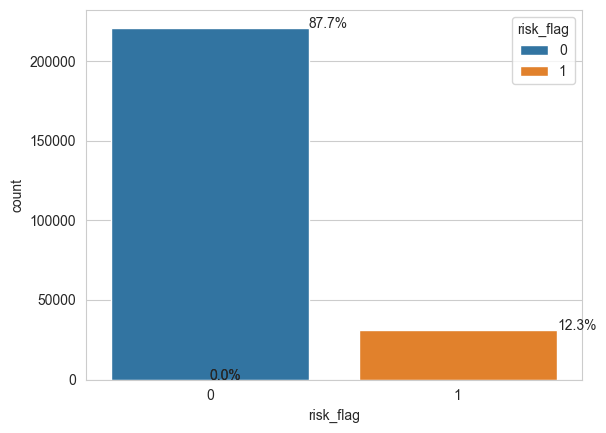

In [21]:
total = float(len(data))

sns.set_style('whitegrid')
ax=sns.countplot(data=df, hue='risk_flag', x='risk_flag')

display_percentage_countplot(ax, total)

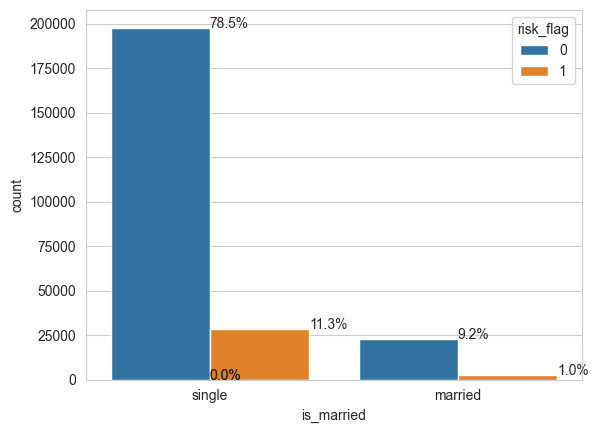

In [22]:
sns.set_style('whitegrid')
ax=sns.countplot(data=data, hue='risk_flag', x='is_married')
display_percentage_countplot(ax, total)

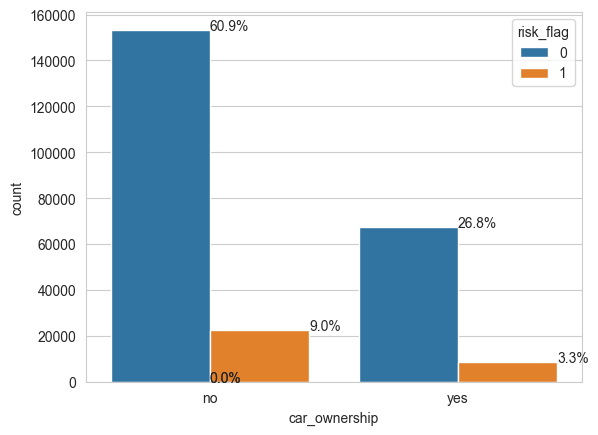

In [23]:
sns.set_style('whitegrid')
ax=sns.countplot(data=data, hue='risk_flag', x='car_ownership')
display_percentage_countplot(ax, total)

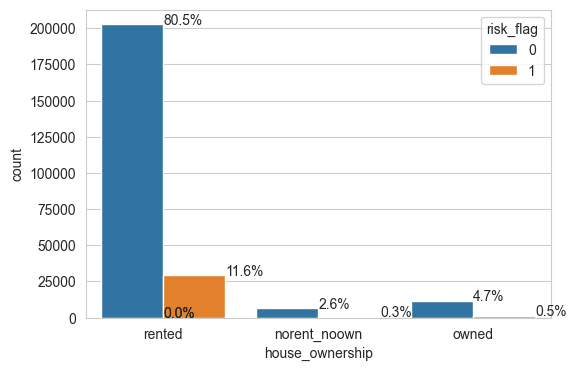

In [24]:
plt.figure(figsize=(6,4))
ax=sns.countplot(data=data, hue='risk_flag', x='house_ownership')
display_percentage_countplot(ax, total)

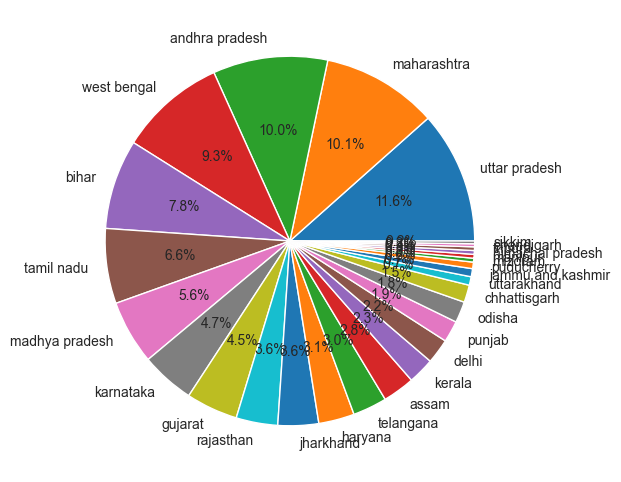

In [25]:
plt.subplots(figsize=(6, 6))
plt.pie(data=data.state, x=data.state.value_counts(), labels=data.state.value_counts().index, autopct='%1.1f%%')
plt.show()

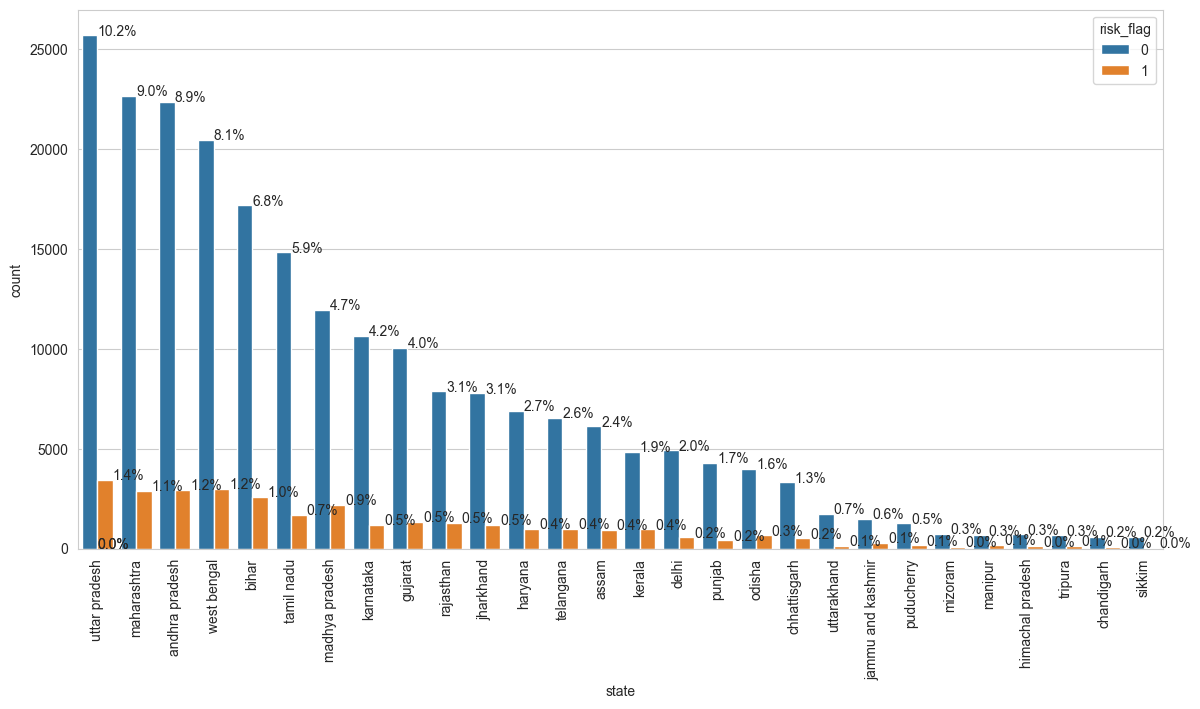

In [26]:
plt.figure(figsize=(14,7))
ax=sns.countplot(data=data, hue='risk_flag', x='state', 
                order = data['state'].value_counts().index)
plt.xticks(rotation=90)
display_percentage_countplot(ax, total)

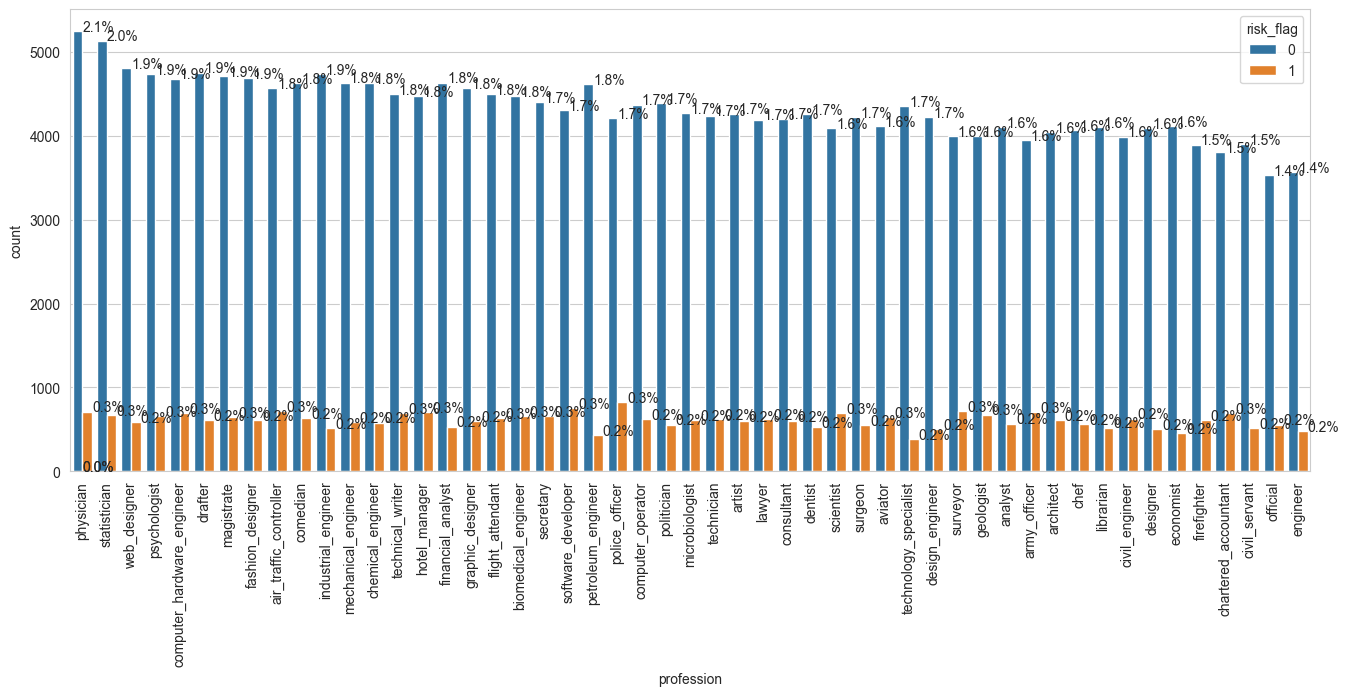

In [27]:
plt.figure(figsize=(16,6))
ax=sns.countplot(data=data, hue='risk_flag', x='profession',
                order = data['profession'].value_counts().index)
plt.xticks(rotation=90)

display_percentage_countplot(ax, total)

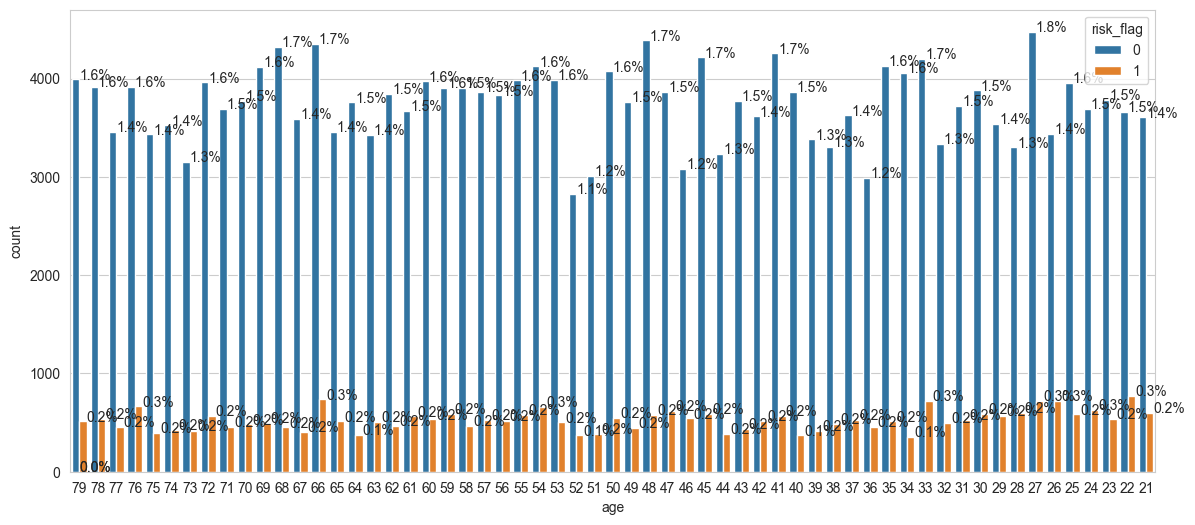

In [28]:
plt.figure(figsize=(14,6))

order = sorted(data['age'].unique(), reverse=True)
ax = sns.countplot(data=data, hue='risk_flag', x='age', order=order)
display_percentage_countplot(ax, total)

In [29]:
#Number of customers that have income less that 2 Lakhs per year
data['income'][data['income']<200000].count()

np.int64(4407)

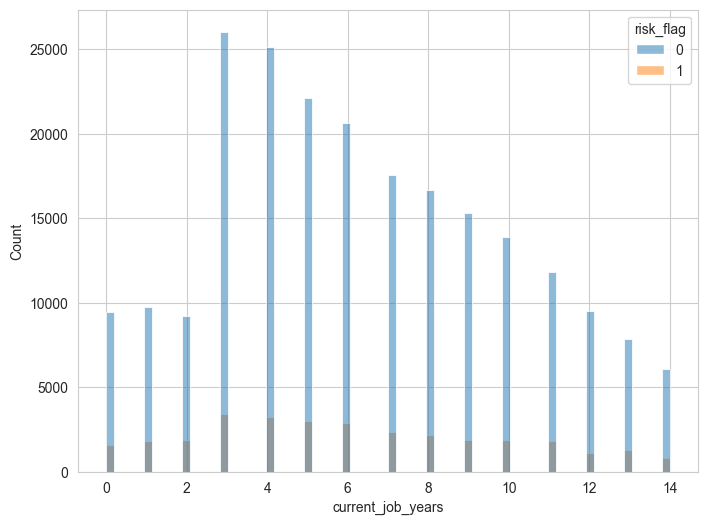

In [30]:
plt.figure(figsize=(8,6))
sns.histplot(data=data, x='current_job_years', hue='risk_flag')
plt.show()

In [31]:
data.current_house_years.value_counts()

current_house_years
11    51873
12    51791
13    50659
14    49003
10    48674
Name: count, dtype: int64

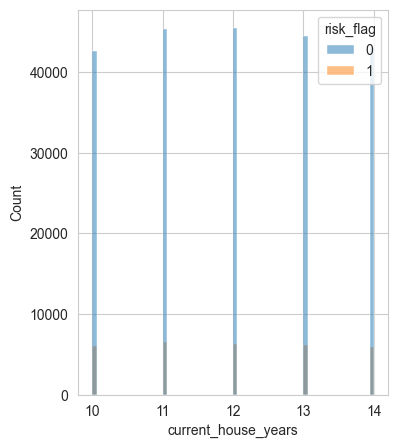

In [32]:
plt.figure(figsize=(4,5))
sns.histplot(data=data, x='current_house_years', hue='risk_flag' , legend=True)
plt.show()

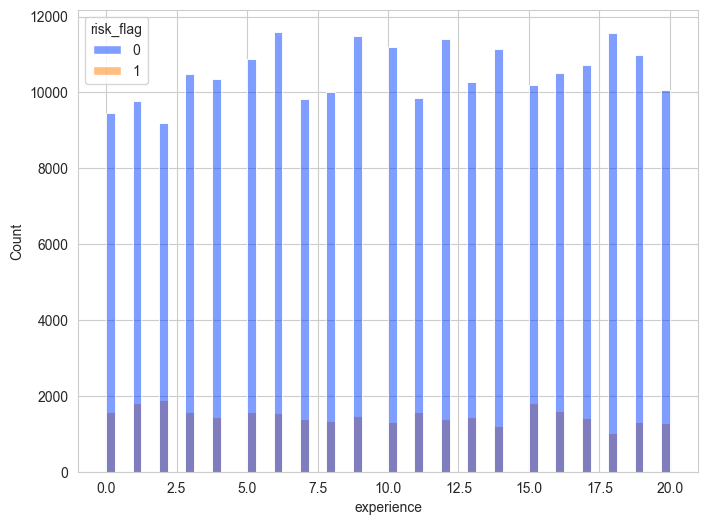

In [33]:
plt.figure(figsize=(8,6))
sns.histplot(data=data, x='experience', hue='risk_flag', palette='bright')
plt.show()

In [34]:
#calculating percentage defaulting risk of every city
city_risk_flag_series=data.groupby('city')['risk_flag'].mean().sort_values(ascending = False).reset_index()
city_risk_flag=pd.DataFrame(data=city_risk_flag_series)
city_risk_flag.rename(columns={'risk_flag':'risk_flag_dec'}, inplace=True)
city_risk_flag['risk_flag_pct']=city_risk_flag['risk_flag_dec'].apply(lambda x: round(x*100, 3))
city_risk_flag.loc[:10, :]

,city,risk_flag_dec,risk_flag_pct
0,bhubaneswar,0.326194,32.619
1,gwalior,0.272727,27.273
2,bettiah,0.266958,26.696
3,kochi,0.252862,25.286
4,raiganj,0.239554,23.955
5,purnia,0.238866,23.887
6,barasat,0.238702,23.870
7,sikar,0.238452,23.845
8,buxar,0.231472,23.147
9,satna,0.225681,22.568


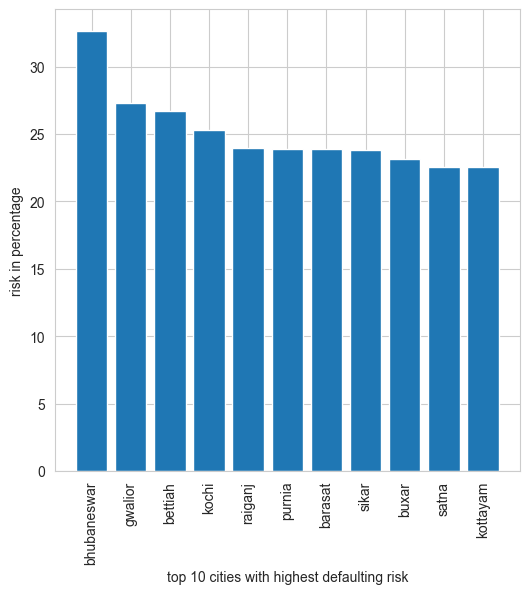

In [35]:
plt.subplots(figsize=(6, 6))
plt.bar(data=city_risk_flag.loc[:10, :], x='city', height='risk_flag_pct')
plt.xticks(rotation=90)
plt.xlabel("top 10 cities with highest defaulting risk")
plt.ylabel("risk in percentage")
plt.show()

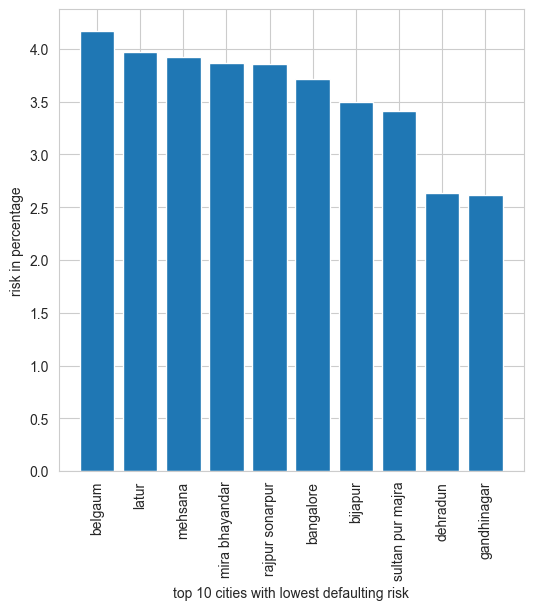

In [36]:
plt.subplots(figsize=(6, 6))
plt.bar(data=city_risk_flag.tail(10), x='city', height='risk_flag_pct')
plt.xticks(rotation=90)
plt.xlabel("top 10 cities with lowest defaulting risk")
plt.ylabel("risk in percentage")
plt.show() 

In [39]:
#calculating percentage defaulting risk of every state

state_risk_flag_series = data.groupby('state')['risk_flag'].mean().sort_values(ascending=False).reset_index()
state_risk_flag = pd.DataFrame(state_risk_flag_series)
state_risk_flag.rename(columns={'risk_flag': 'state_risk_flag_dec'}, inplace=True)
state_risk_flag['state_risk_flag_pct'] = state_risk_flag['state_risk_flag_dec'].apply(lambda x: round(x * 100, 3))
state_risk_flag.head(5)


,state,state_risk_flag_dec,state_risk_flag_pct
0,manipur,0.215548,21.555
1,tripura,0.168109,16.811
2,kerala,0.167097,16.710
3,jammu and kashmir,0.158989,15.899
4,madhya pradesh,0.154369,15.437


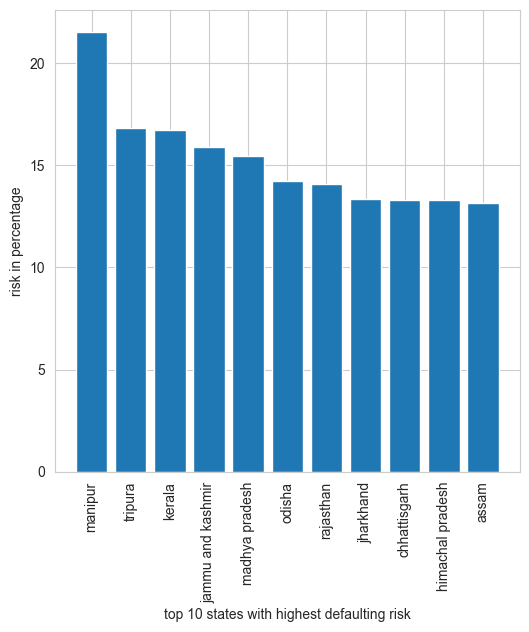

In [40]:
plt.subplots(figsize=(6, 6))
plt.bar(data=state_risk_flag.loc[:10, :], x='state', height='state_risk_flag_pct')
plt.xticks(rotation=90)
plt.xlabel("top 10 states with highest defaulting risk")
plt.ylabel("risk in percentage")
plt.show()

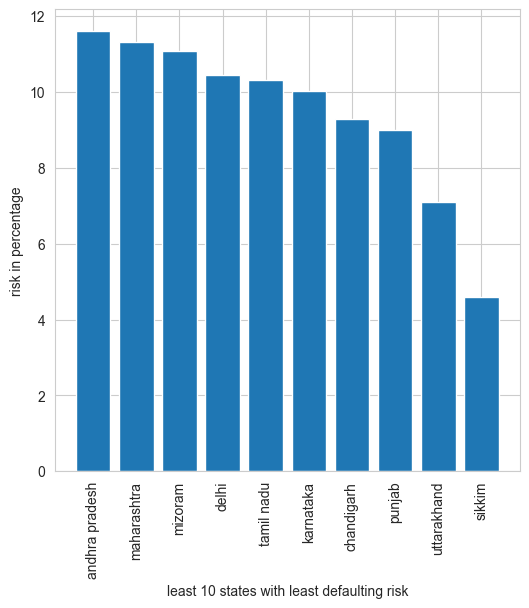

In [41]:
plt.subplots(figsize=(6, 6))
plt.bar(data=state_risk_flag.tail(10), x='state', height='state_risk_flag_pct')
plt.xticks(rotation=90)
plt.xlabel("least 10 states with least defaulting risk")
plt.ylabel("risk in percentage")
plt.show()

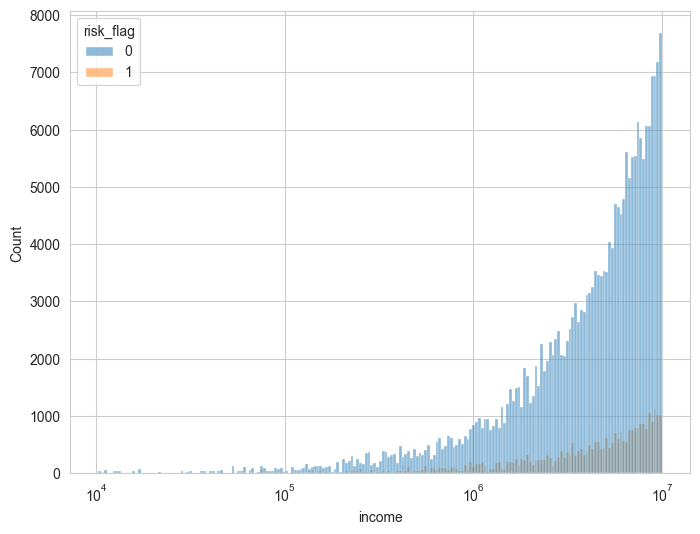

In [42]:
plt.figure(figsize=(8,6))
sns.histplot(data=data, x='income', hue='risk_flag', log_scale=True , legend=True)
plt.show()

<h2>3.4 Multivariate Analysis</h2>

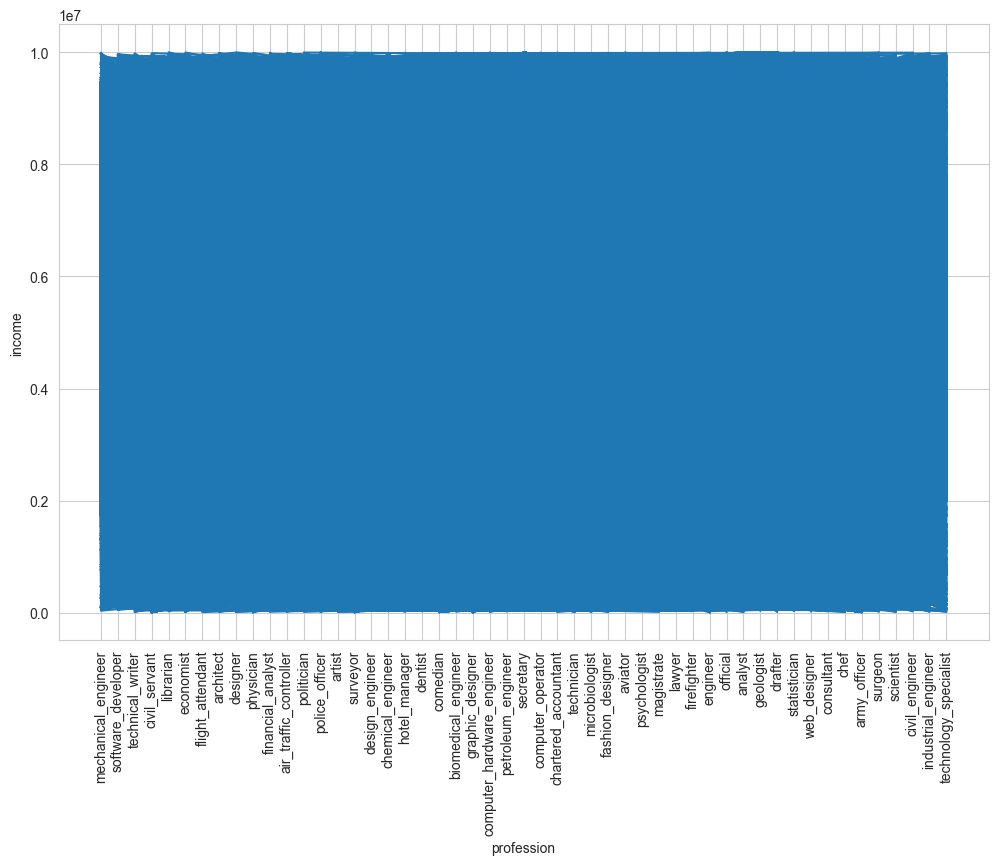

In [43]:
#profession vs income
plt.figure(figsize=(12,8))
plt.plot(data['profession'], data['income'])
plt.xlabel('profession')
plt.ylabel('income')
plt.rcParams['agg.path.chunksize'] = 10000
plt.xticks(rotation=90)
plt.show()

<Figure size 400x400 with 0 Axes>

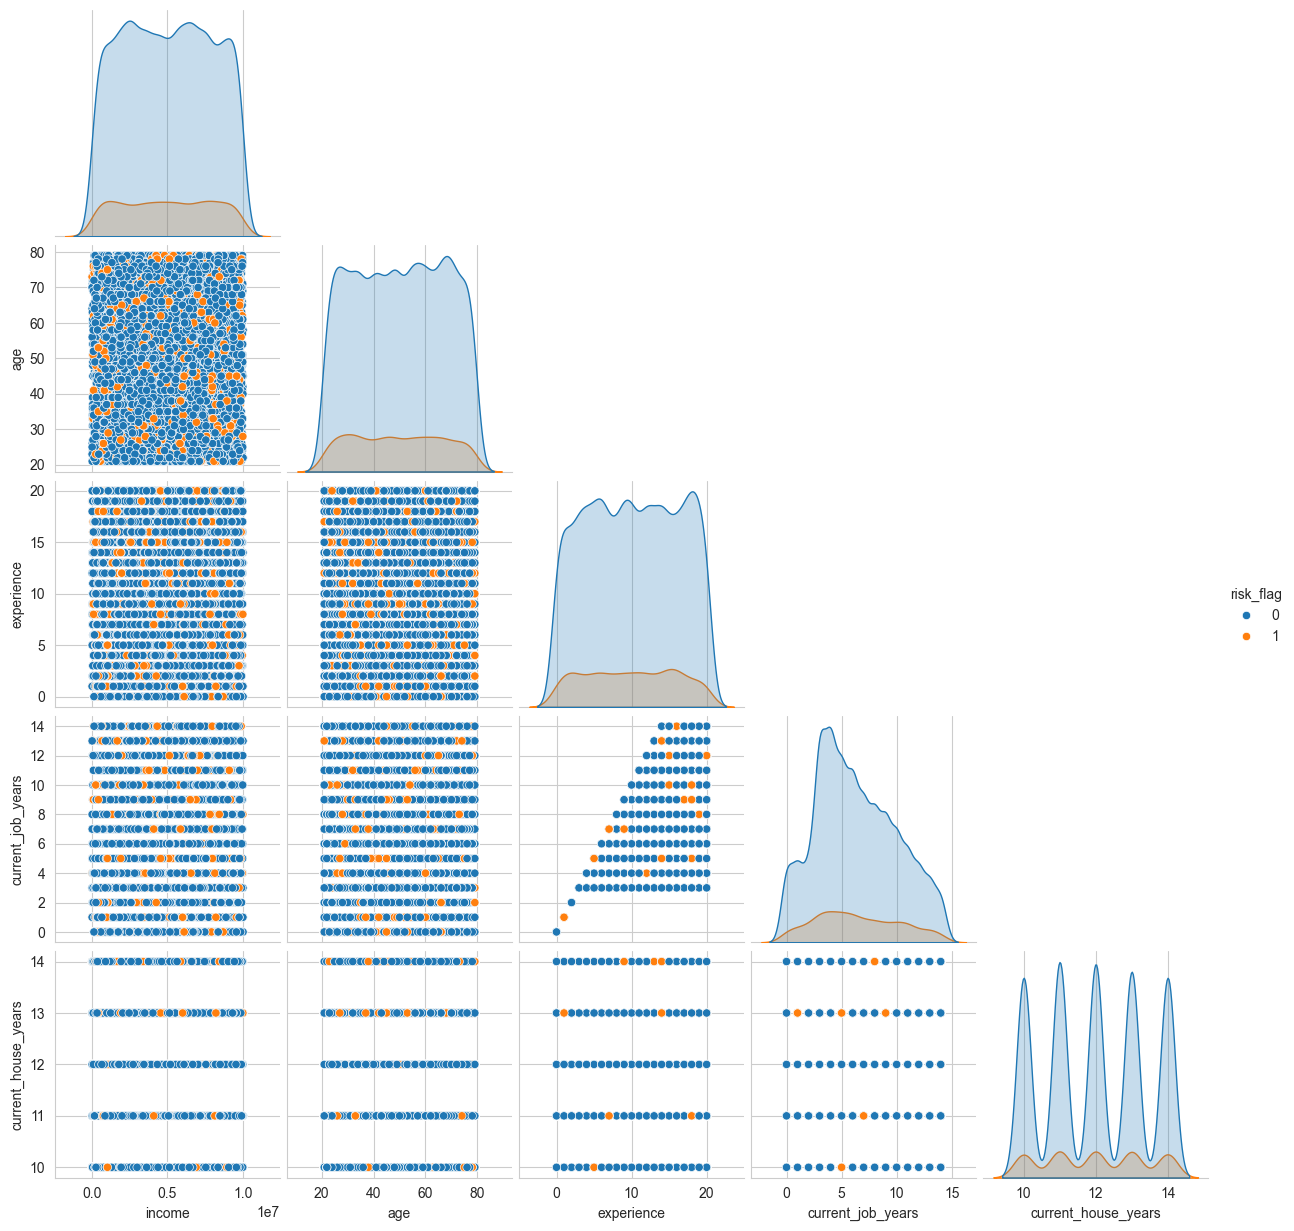

In [44]:
#pairplot on all numerical data
plt.figure(figsize=(4,4))
sns.set_style("whitegrid")
sns.pairplot(numerical_data.iloc[:20000,:], hue="risk_flag", corner=True)
plt.show()

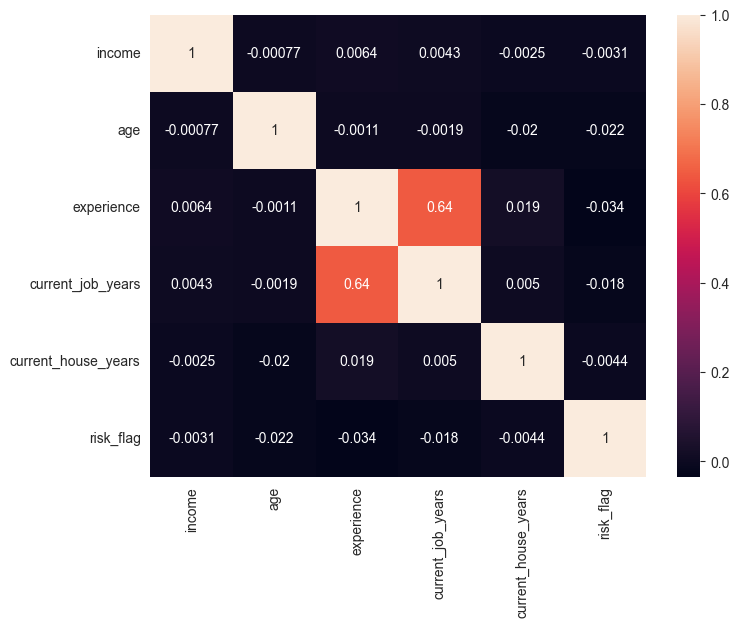

In [47]:
#spearman correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(numerical_data.corr(method='spearman'), annot=True)
plt.show()

### Observations:
- We can see that 87.7% of the observations involves no risk of defaulting and 12.3% has risk of defaulting
- States like Uttar Pradesh, Maharashtra and Andra Pradesh share most of the data points
- Cities like Bhubaneshwar, Gwalior and Bettiah have high risk of defaulting involving 25-30% of defaulting cases
- Cities like Bangalore, Dehradun, Belgaum, Latur have customers that defaulted least in the past
- 70% of the customers don't own a car and about 80% of customers are not married
- 92% of the customers live in a rented house
- we can observe in the correlation plot that experience and current_job_years are correlated to each other

<h2>3.5 Train Test Split</h2>

In [48]:
y_true=data['risk_flag']

In [49]:
#using stratify=y_true to have equal number of datapoints both in train and test datasets 
data_train, data_test, y_train,  y_test = train_test_split(data.drop('risk_flag', axis=1), y_true, 
                                                          stratify=y_true, test_size=0.3)

In [50]:
data_train=data_train.reset_index(drop=True)
data_test=data_test.reset_index(drop=True)
y_train=y_train.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)

In [51]:
data_train

,income,age,experience,is_married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years
0,4189025,66,15,single,rented,no,artist,medininagar,jharkhand,12,14
1,7851638,51,9,single,rented,no,engineer,bidhannagar,west bengal,9,12
2,6876962,49,18,single,rented,no,artist,hubli dharwad,karnataka,9,12
3,4827008,51,5,single,rented,no,mechanical_engineer,aurangabad,maharashtra,5,10
4,5125207,54,5,single,rented,no,software_developer,guwahati,assam,5,11
...,...,...,...,...,...,...,...,...,...,...,...
176395,9931632,51,4,married,rented,no,scientist,ozhukarai,puducherry,4,12
176396,7392946,33,12,single,rented,no,surgeon,aizawl,mizoram,8,10
176397,9430306,35,12,single,rented,yes,scientist,gwalior,madhya pradesh,3,13
176398,3802556,58,18,married,rented,yes,design_engineer,bhilai,chhattisgarh,10,14


<h1>4. Feature Engineering and Feature Selection</h1>

In [52]:
data.columns

Index(['income', 'age', 'experience', 'is_married', 'house_ownership',
       'car_ownership', 'profession', 'city', 'state', 'current_job_years',
       'current_house_years', 'risk_flag'],
      dtype='object')

<h2>4.1 Encoding</h2>

In [53]:
featurized_data_train=pd.DataFrame()
featurized_data_test=pd.DataFrame()

<h3>4.1.1 Label Enconding</h3>

In [54]:
#label encoding the binary valued data
featurized_data_train['is_married']=data_train['is_married'].replace({'single' : 0, 'married' : 1})
featurized_data_test['is_married']=data_test['is_married'].replace({'single' : 0, 'married' : 1})

In [55]:
label_encoder=LabelEncoder()
featurized_data_train['car_ownership']=label_encoder.fit_transform(data_train['car_ownership'])
featurized_data_test['car_ownership']=label_encoder.fit_transform(data_test['car_ownership'])

<h3>4.1.2 One Hot Enconding</h3>

In [56]:
#you can also use sklearn.preprocessing.OneHotEncoder for one hot encoding
featurized_data_train_house_ownership=pd.get_dummies(data=data_train['house_ownership'])
featurized_data_test_house_ownership=pd.get_dummies(data=data_test['house_ownership'])

In [57]:
featurized_data_train_profession=pd.get_dummies(data=data_train['profession'])
featurized_data_test_profession=pd.get_dummies(data=data_test['profession'])

In [58]:
featurized_data_train_state=pd.get_dummies(data=data_train['state'])
featurized_data_test_state=pd.get_dummies(data=data_test['state'])

In [59]:
#concatinating all the encoded data, we dropped city features as it varies too much and reduces the auc score
featurized_data_train=pd.concat([featurized_data_train,featurized_data_train_house_ownership,
                                 featurized_data_train_profession,
                                 featurized_data_train_state,
                          data_train[['income','age', 'experience', 'current_job_years', 'current_house_years']]], axis=1)
featurized_data_test=pd.concat([featurized_data_test, featurized_data_test_house_ownership,
                                featurized_data_test_profession,featurized_data_test_state,
                          data_test[['income','age', 'experience', 'current_job_years', 'current_house_years']]], axis=1)

In [60]:
featurized_data_train.head()

,is_married,car_ownership,norent_noown,owned,rented,air_traffic_controller,analyst,architect,army_officer,artist,...,telangana,tripura,uttar pradesh,uttarakhand,west bengal,income,age,experience,current_job_years,current_house_years
0,0,0,False,False,True,False,False,False,False,True,...,False,False,False,False,False,4189025,66,15,12,14
1,0,0,False,False,True,False,False,False,False,False,...,False,False,False,False,True,7851638,51,9,9,12
2,0,0,False,False,True,False,False,False,False,True,...,False,False,False,False,False,6876962,49,18,9,12
3,0,0,False,False,True,False,False,False,False,False,...,False,False,False,False,False,4827008,51,5,5,10
4,0,0,False,False,True,False,False,False,False,False,...,False,False,False,False,False,5125207,54,5,5,11


In [61]:
featurized_data_test.head()

,is_married,car_ownership,norent_noown,owned,rented,air_traffic_controller,analyst,architect,army_officer,artist,...,telangana,tripura,uttar pradesh,uttarakhand,west bengal,income,age,experience,current_job_years,current_house_years
0,0,0,False,False,True,False,False,False,False,False,...,False,False,False,False,False,9962662,79,19,7,11
1,0,0,False,False,True,False,False,False,False,False,...,False,False,False,False,False,648663,27,9,8,13
2,0,1,False,False,True,False,False,False,False,False,...,False,False,True,False,False,1392884,29,11,5,14
3,0,0,False,False,True,False,False,False,False,False,...,False,False,False,False,False,9846008,48,0,0,13
4,0,1,False,False,True,False,False,False,False,False,...,False,False,False,False,False,9674252,41,7,6,13


<h2>4.2 Data Balancing</h2>

<h3>4.2.1 Data Oversampling using SMOTE</h3>

Synthetic Minority Oversampling Technique (SMOTE) works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

In [62]:
#oversampling the positive labelled data points using SMOTE
over_sampler=SMOTE(random_state=2)
oversampled_featurized_data_train_x, oversampled_featurized_data_train_y=over_sampler.fit_resample(featurized_data_train,
                                                                                        y_train)

oversampled_featurized_data_test_x, oversampled_featurized_data_test_y=over_sampler.fit_resample(featurized_data_test,
                                                                                        y_test)

<h3>4.2.2 Feature Scaling</h3>

In [63]:
# Scale the data and tranform only the test data
stdScaler=StandardScaler()
scaled_featurized_data_train=stdScaler.fit_transform(oversampled_featurized_data_train_x)
scaled_featurized_data_test=stdScaler.transform(oversampled_featurized_data_test_x)

In [64]:
scaled_featurized_data_train=pd.DataFrame(scaled_featurized_data_train, columns=oversampled_featurized_data_train_x.columns)
scaled_featurized_data_train.head(5)

,is_married,car_ownership,norent_noown,owned,rented,air_traffic_controller,analyst,architect,army_officer,artist,...,telangana,tripura,uttar pradesh,uttarakhand,west bengal,income,age,experience,current_job_years,current_house_years
0,-0.30533,-0.604083,-0.153186,-0.20438,0.291905,-0.142644,-0.129523,-0.134764,-0.13615,7.587979,...,-0.16955,-0.057455,-0.337747,-0.074064,-0.308595,-0.274731,0.977494,0.879324,1.594408,1.489623
1,-0.30533,-0.604083,-0.153186,-0.20438,0.291905,-0.142644,-0.129523,-0.134764,-0.13615,-0.131787,...,-0.16955,-0.057455,-0.337747,-0.074064,3.240494,0.989117,0.090528,-0.131099,0.768469,0.037305
2,-0.30533,-0.604083,-0.153186,-0.20438,0.291905,-0.142644,-0.129523,-0.134764,-0.13615,7.587979,...,-0.16955,-0.057455,-0.337747,-0.074064,-0.308595,0.652788,-0.027734,1.384536,0.768469,0.037305
3,-0.30533,-0.604083,-0.153186,-0.20438,0.291905,-0.142644,-0.129523,-0.134764,-0.13615,-0.131787,...,-0.16955,-0.057455,-0.337747,-0.074064,-0.308595,-0.054584,0.090528,-0.804714,-0.332783,-1.415013
4,-0.30533,-0.604083,-0.153186,-0.20438,0.291905,-0.142644,-0.129523,-0.134764,-0.13615,-0.131787,...,-0.16955,-0.057455,-0.337747,-0.074064,-0.308595,0.048315,0.267921,-0.804714,-0.332783,-0.688854


In [65]:
scaled_featurized_data_test=pd.DataFrame(scaled_featurized_data_test, columns=oversampled_featurized_data_test_x.columns)
scaled_featurized_data_test.head(5)

,is_married,car_ownership,norent_noown,owned,rented,air_traffic_controller,analyst,architect,army_officer,artist,...,telangana,tripura,uttar pradesh,uttarakhand,west bengal,income,age,experience,current_job_years,current_house_years
0,-0.30533,-0.604083,-0.153186,-0.20438,0.291905,-0.142644,-0.129523,-0.134764,-0.13615,-0.131787,...,-0.16955,-0.057455,-0.337747,-0.074064,-0.308595,1.717563,1.746198,1.552939,0.217843,-0.688854
1,-0.30533,-0.604083,-0.153186,-0.20438,0.291905,-0.142644,-0.129523,-0.134764,-0.13615,-0.131787,...,-0.16955,-0.057455,-0.337747,-0.074064,-0.308595,-1.496395,-1.328618,-0.131099,0.493156,0.763464
2,-0.30533,1.655402,-0.153186,-0.20438,0.291905,-0.142644,-0.129523,-0.134764,-0.13615,-0.131787,...,-0.16955,-0.057455,2.960793,-0.074064,-0.308595,-1.239588,-1.210355,0.205709,-0.332783,1.489623
3,-0.30533,-0.604083,-0.153186,-0.20438,0.291905,-0.142644,-0.129523,-0.134764,-0.13615,-0.131787,...,-0.16955,-0.057455,-0.337747,-0.074064,-0.308595,1.677309,-0.086865,-1.646733,-1.709348,0.763464
4,-0.30533,1.655402,-0.153186,-0.20438,0.291905,-0.142644,-0.129523,-0.134764,-0.13615,-0.131787,...,-0.16955,-0.057455,-0.337747,-0.074064,-0.308595,1.618042,-0.500783,-0.467906,-0.057470,0.763464


In [66]:
final_train=scaled_featurized_data_train.copy()
final_test=scaled_featurized_data_test.copy()
final_train_labels=oversampled_featurized_data_train_y.copy()
final_test_labels=oversampled_featurized_data_test_y.copy()

In [67]:
print(final_train.shape)
print(final_train_labels.shape)
print(final_test.shape)
print(final_test_labels.shape)

(309406, 89)
(309406,)
(132602, 89)
(132602,)


<h1>5. Machine Learning Models</h1>

<h3>5.1 Random Forest Classifier</h3>

<h4>5.1.1. Best parameter fitting</h4>

In [85]:
def randomForestModel(trainData, trainLabels, testData, testLabels, optimum_params):
    
    global rf_clf
    rf_clf = RandomForestClassifier(n_estimators=optimum_params['n_estimators'], 
                                    criterion=optimum_params['criterion'], 
                                    max_depth=optimum_params['max_depth'],  
                                    random_state=42,
                                    n_jobs= -1)

    rf_clf.fit(trainData, trainLabels)
    print("Best AUC score on optimum parameters is: {}"\
                                    .format( round(roc_auc_score(testLabels,rf_clf.predict_proba(testData)[:, 1]), 5)))
    
    #plot ROC AUC Curve
    plt.figure(figsize=(10, 5))
    train_roc = RocCurveDisplay.from_estimator(rf_clf, trainData, trainLabels, name="Train ROC")
    test_roc = RocCurveDisplay.from_estimator(rf_clf, testData, testLabels, name="Test ROC")

    # Title and legend
    plt.title("ROC Curve - Train vs Test")
    plt.legend()
    plt.show()

    # Plot confusion matrix
    confusion_mat = confusion_matrix(testLabels, rf_clf.predict(testData))
    df_confusion_matrix = pd.DataFrame(confusion_mat, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])

    plt.figure(figsize=(6, 5))
    sns.heatmap(df_confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    
    return rf_clf

In [86]:
rf_optimum_params={'criterion': 'gini', 'max_depth': 50, 'n_estimators': 800}

Best AUC score on optimum parameters is: 0.96266


<Figure size 1000x500 with 0 Axes>

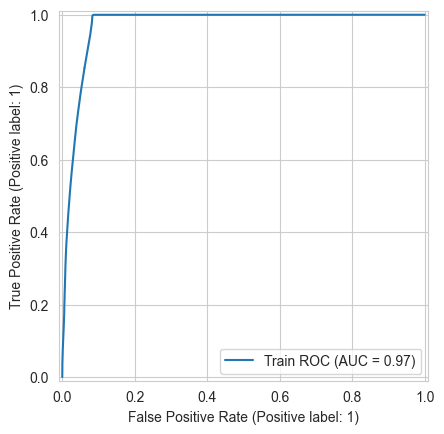

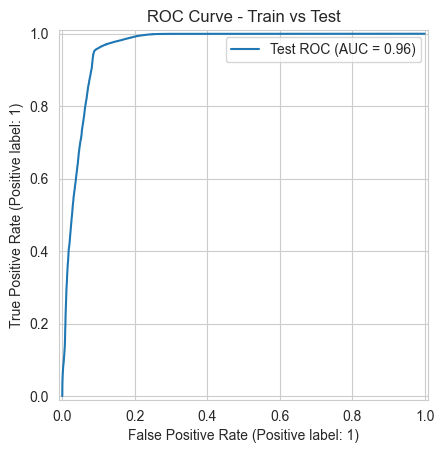

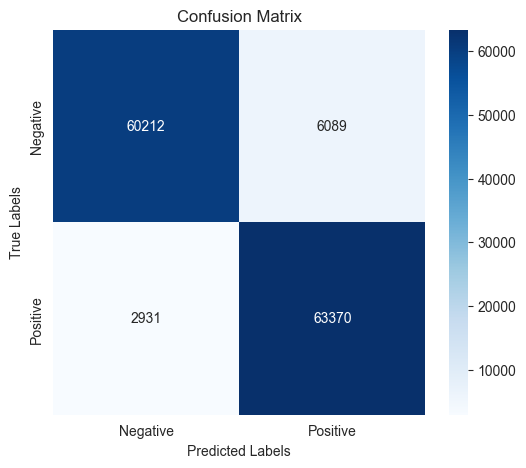

In [87]:
rf_clf_model=randomForestModel(final_train,final_train_labels,final_test,final_test_labels, 
                  rf_optimum_params)

In [100]:
import joblib

joblib.dump(rf_clf_model, "random_forest_model.pkl")

# # Load RandomForest model
# rf_loaded = joblib.load("random_forest_model.pkl")

['random_forest_model.pkl']

<h3>5.2. XGBoost Classifier</h3>

<h4>5.2.1 Best parameters fitting</h4>

In [91]:
def xgbClassifireModel(trainData, trainLabels, testData, testLabels, optimum_params):
    
    global xgb_clf
    xgb_clf = XGBClassifier(n_estimators= optimum_params['n_estimators'],
                                max_depth=optimum_params['max_depth'],
                                eval_metric='auc',
                                random_state=42,
                                n_jobs= -1,
                                verbosity = 1
                                )
    xgb_clf.fit(trainData, trainLabels)
    print("Best AUC score on optimum parameters is: {}"\
                                    .format( round(roc_auc_score(testLabels,xgb_clf.predict_proba(testData)[:, 1]), 5)))

    #plot ROC AUC Curve
    plt.figure(figsize=(10, 5))
    train_roc = RocCurveDisplay.from_estimator(xgb_clf, trainData, trainLabels, name="Train ROC")
    test_roc = RocCurveDisplay.from_estimator(xgb_clf, testData, testLabels, name="Test ROC")
    plt.title("ROC Curve - Train vs Test")
    plt.legend()
    plt.show() 
    
    #Plot confusion matrix
    confusion_mat=confusion_matrix(testLabels, xgb_clf.predict(testData))
    df_confusion_matrix=pd.DataFrame(confusion_mat, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
    sns.heatmap(df_confusion_matrix, annot=True, fmt="d")
    plt.title("ROC AUC Curve")
    plt.title("Confusiion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.legend('right bottom')
    plt.show()
    
    return xgb_clf

In [92]:
optimum_params_xgb={'booster': 'gbtree', 'eval_metric': 'auc', 'max_depth': 50, 'n_estimators': 800, 'objective': 'binary:logistic', 'predictor': 'cpu_predictor', 'tree_method': 'hist'}

Best AUC score on optimum parameters is: 0.96922


<Figure size 1000x500 with 0 Axes>

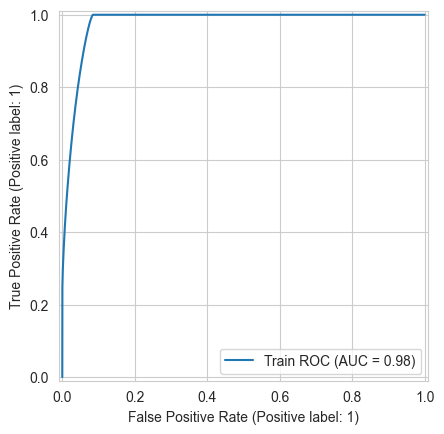

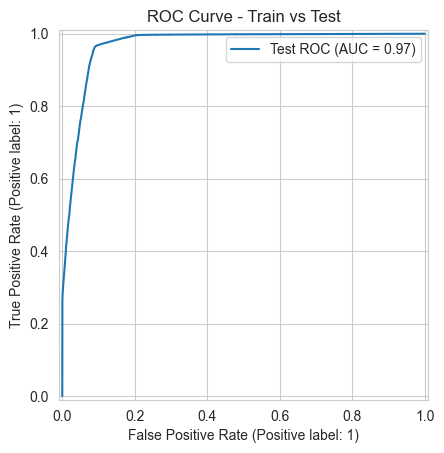

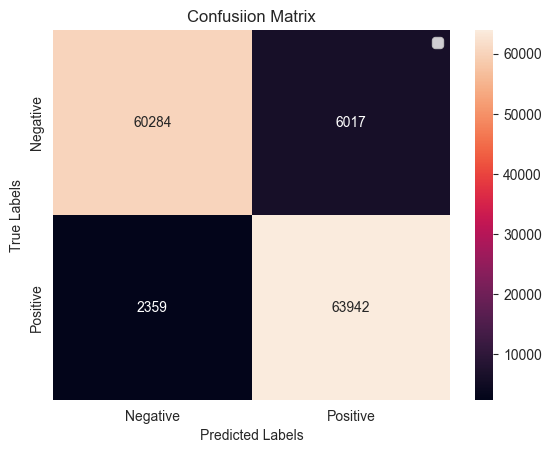

In [93]:
xgb_clf_model=xgbClassifireModel(final_train, final_train_labels, final_test, final_test_labels, optimum_params_xgb)

In [101]:
joblib.dump(xgb_clf_model, "xgboost_model.pkl")
# xgb_loaded = joblib.load("xgboost_model.pkl")

['xgboost_model.pkl']

In [98]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc

# Define the Neural Network Model
def neuralnetwork(trainData, trainLabels, testData, testLabels):
    nn_model = Sequential([
        Dense(128, activation='relu', input_shape=(trainData.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    # Compile the model
    nn_model.compile(optimizer=Adam(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=['AUC'])

    # Train the model
    nn_model.fit(trainData, trainLabels, validation_data=(testData, testLabels), epochs=10, batch_size=32)

    test_loss, test_auc = nn_model.evaluate(testData, testLabels)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test AUC-ROC: {test_auc:.4f}")

    y_pred_proba = nn_model.predict(testData).flatten()

    # Convert to binary labels (default threshold = 0.5)
    y_pred = (y_pred_proba >= 0.5).astype(int)

    fpr, tpr, _ = roc_curve(testLabels, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    return nn_model


Epoch 1/10
9669/9669 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - AUC: 0.7388 - loss: 0.5766 - val_AUC: 0.9141 - val_loss: 0.3909
Epoch 2/10
9669/9669 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - AUC: 0.8740 - loss: 0.4408 - val_AUC: 0.9433 - val_loss: 0.3249
Epoch 3/10
9669/9669 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - AUC: 0.9067 - loss: 0.3869 - val_AUC: 0.9507 - val_loss: 0.2936
Epoch 4/10
9669/9669 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - AUC: 0.9186 - loss: 0.3612 - val_AUC: 0.9548 - val_loss: 0.2693
Epoch 5/10
9669/9669 ━━━━━━━━━━━━━━━━━━━━ 54s 6ms/step - AUC: 0.9271 - loss: 0.3408 - val_AUC: 0.9558 - val_loss: 0.2551
Epoch 6/10
9669/9669 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - AUC: 0.9328 - loss: 0.3259 - val_AUC: 0.9563 - val_loss: 0.2506
Epoch 7/10
9669/9669 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.9355 - loss: 0.3179 - val_AUC: 0.9569 - val_loss: 0.2465
Epoch 8/10
9669/9669 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - AUC: 0.9376 - loss: 0.3105 - val_AUC: 0.9570 - val_loss: 0.2388
Epoch 9/10
9669/9669 ━━━━━━━━━━━

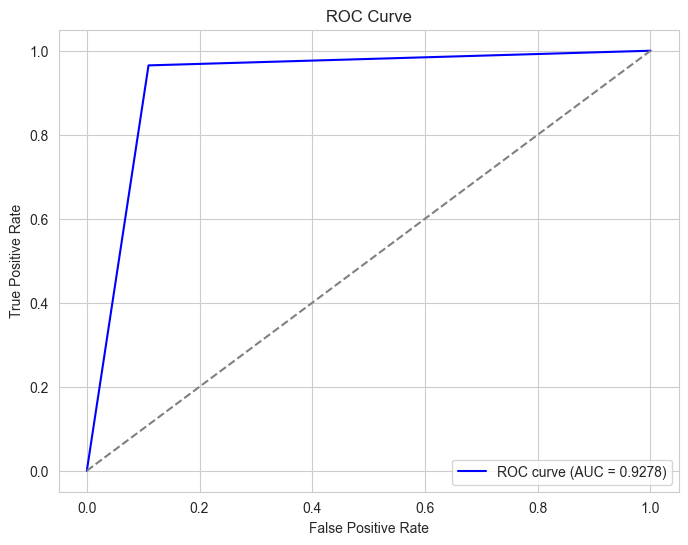

In [99]:
nn_model=neuralnetwork(final_train, final_train_labels, final_test, final_test_labels)

In [102]:
nn_model.save("neural_network_model.h5")

AttributeError: 'NoneType' object has no attribute 'save'